# Harmonisation strategies
## Author: David M Cash
## Principal Research Fellow, Dementia Research Centre, UCL Queen Square Institute of Neurology

## Introduction
This notebook was made as part of the **Health and Bioscience IDEAS** training programme, funded by the [UKRI Innovation Scholars](https://www.ukri.org/opportunity/innovation-scholars-data-science-training-in-health-bioscience/) Data Science Training in Health and Bioscience. Please visit [our website](https://healthbioscienceideas.github.io/) for more information.

This notebook will give a brief example of how to correct, or harmonize for site-related differences in image biomarkers. This problem is cropping up more and more often as we need multi-site data to have large enough sample sizes for many research applications, particularly for those that are based on machine learning and need a large enough training set to produce an accurate model. For more background on this, please see the [accompanying documenation](https://healthbioscienceideas.github.io/demon-imaging-harmonisation/). 


In [1]:
import os
import nest_asyncio
nest_asyncio.apply()
import numpy as np
import pandas as pd
import datalad.api as dl

As in the previous notebook, we will grab the data for the lesson using datalad. This time we will ne using a spreadsheet that has  all the imgaging volumes for the study and read it into memory. This data is a limited dataset from [GENFI](https://www.genfi.org/) a multi-site study of genetic frontotemporal dementia.

In [5]:
dl_source='https://github.com/HealthBioscienceIDEAS/demon-imaging-data.git'
sample=dl.clone(dl_source,path='/tmp/sample',description='Cloned sample dataset for import')
sample.update(merge=True)
sample.siblings(action='enable',name='demons-data')
in_file=sample.get('./GENFI_DEMON_SPREADSHEET.xlsx')

[INFO] Fetching updates for Dataset(/tmp/sample) 


.: demons-data(?) [git]


For the pusporses of some of the regression methods, I am making some of the variables categorical in nature. 

In [6]:
df_xsec=pd.read_excel(in_file[0]['path'])
df_xsec['Sex']=pd.Categorical(df_xsec['Sex'],categories=[0,1])
df_xsec['Sex']=df_xsec['Sex'].cat.rename_categories(['Female','Male'])
df_xsec['Site'] = pd.Categorical(df_xsec['Site'],categories=np.arange(23))
df_xsec['Group']=pd.Categorical(df_xsec['Group'],categories=[0,1,2])
df_xsec['Group']=df_xsec['Group'].cat.rename_categories(['Non-carrier','Presymptomatic','Symptomatic'])

Next I will produce a quick crosstab to show the number of individuals scanned at each site and with each scanner. Here are some of the key points for this table:
* Some sites have a lot more data than others. The largest site has 143 individuals while the smallest has 2.
* Out of the 22 sites, there are only 7 scanner models being used.
* Some sites have switched scanners midway through the study (See Site 8).

In [7]:
pd.crosstab(df_xsec['Site'],df_xsec['Scanner'])

Scanner,GE 1.5T,GE 3T,Philips 3T,Siemens 1.5T,Siemens Prisma 3T,Siemens Skyra 3T,Siemens Trio 3T
Site,,,,,,,
0,0,0,0,0,0,8,20
1,0,0,45,0,0,0,0
2,0,0,0,0,3,0,0
3,0,0,143,0,0,0,0
4,0,0,3,0,0,0,0
5,0,25,0,0,6,0,0
6,0,0,18,0,0,0,0
7,0,0,0,0,10,0,12
8,0,0,0,33,0,36,0


## Analysis
The participants in the dataset fall into thre main clinical classifications (variable name **Group**). We want to examine what the between-group differences are for the volume of the insula, a key brain structure known to be affected early in frontotemporal dementia. But we do any statstical analysis, let;s get a few summary statistics, including the sample size and mean(standard deviation), min and max of three variables: 
* Age,
* EYO - Estimated Years to symptom onset, and 
* TIV - total intracranial volume (TIV), a variable often used as a proxy for head size. Unlike other volumes in this spreadsheet, TIV is in ml not mm$^3$ (1ml=1000mm$^3$)

In [15]:
df_xsec.groupby("Group").agg(
    {
        "ID": ["count"],
        "Age": ["mean", "std", "min", "max" ],
        "EYO": ["mean", "std", "min", "max" ],
        "TIV": ["mean", "std", "min", "max" ]
    }
).style.format(precision=1)

Some things to note from this table:
* The symptomatic carriers are much older than the presymptomatic, and they are expected to be past onset.
* The non-carriers are pretty much the same age and EYO, which is to be expected when you have an autosomal dominant mutation
* The TIV across all groups is pretty much the same.

One more thing to check, the breakdown of sex between groups.

In [19]:
pd.crosstab(df_xsec["Group"],df_xsec["Sex"],normalize='index').style.format(precision=3)

Sex,Female,Male
Group,,
Non-carrier,0.574,0.426
Presymptomatic,0.632,0.368
Symptomatic,0.430,0.570


The non-carrier and presymptomatic carriers have pretty much the same proportion of females and males, while the symptomaitc group have more males 
(Note: test not performed!)

### Simple regression no sites
The first analysis we will do is a very simple linear regression where site is **not** accounted for. We will, however, include  sex, age, and TIV as covariates to deteminre what differences there are between groups when adjusting for these variables. 

In [21]:
import statsmodels.api as stats
import statsmodels.formula.api as statsfx

If you are familiar with R, the regression equations in statsmodels are setup in a similar fashion. So the first model will take into account age, sex, and TIV but *not* site. We will center age and TIV so that the resulting intercept from the regression is more interpetable.
This regression corresponds to the following formula:  
$y_i  = \beta_0 + \beta_1x_{i,Age} + \beta_2x_{i,Male} + \beta_3x_{i,TIV} + \epsilon_i$

In [22]:
df_xsec=df_xsec.dropna(subset=["Group","Age","Sex","TIV"])
df_xsec["Age_centered"]=df_xsec['Age']-df_xsec['Age'].mean()
df_xsec["TIV_centered"]=df_xsec['TIV']-df_xsec['TIV'].mean()
results= statsfx.ols('Insula_volume ~ Group + Age_centered + Sex + TIV_centered',data=df_xsec).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:          Insula_volume   R-squared:                       0.711
Model:                            OLS   Adj. R-squared:                  0.709
Method:                 Least Squares   F-statistic:                     303.5
Date:                Tue, 14 Sep 2021   Prob (F-statistic):          1.72e-163
Time:                        10:20:49   Log-Likelihood:                -5109.0
No. Observations:                 622   AIC:                         1.023e+04
Df Residuals:                     616   BIC:                         1.026e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                1

### Interpretation
Let's look at the results from the regression output:
* The average Insular volume for a female non-carrier of average age (~48 years in this cohort) and average TIV(1420 ml) is 10730mm$^3$. 
* Female presymptomatic carriers of the same mean age and TIV have 233mm$^3$ less volume than the non-carriers, which is statistically significant
* Female symptomatic carriers of the same mean age and TIV have 2147mm$^3$ less volume, which is statistically significant. 
* While there is no significant evidence of any volume difference between males and females, there are clear age and TIV-related differences with every 1000mm$^3$(or 1ml) of TIV resulting in an insula that is 6mm$^3$ bigger, and for every year  of ageing, there is a loss of 41mm$^3$.

Before we go on, let's take a look and see if we can spot differences by site, even though it is not yet in the model. To do that, we will plot the predicted insular volumes based on the lienar regression, and group them by site.


<AxesSubplot:title={'center':'predicted'}, xlabel='[Site]'>

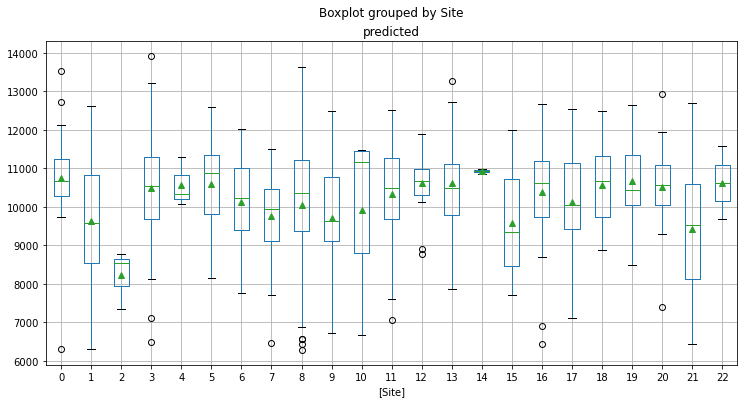

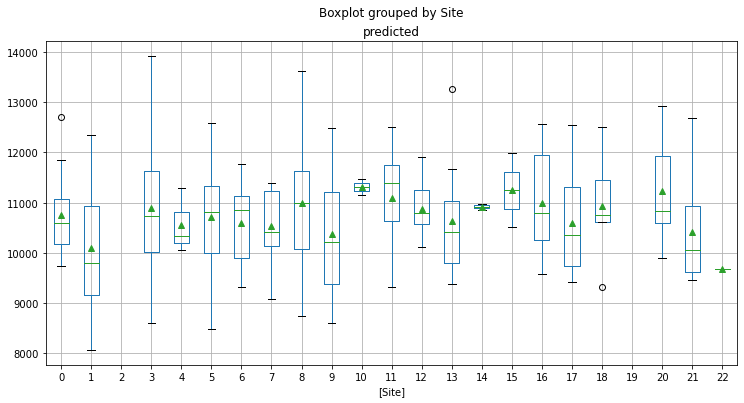

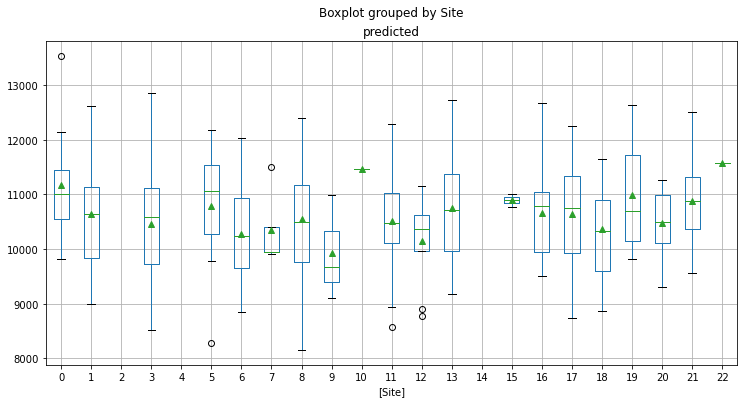

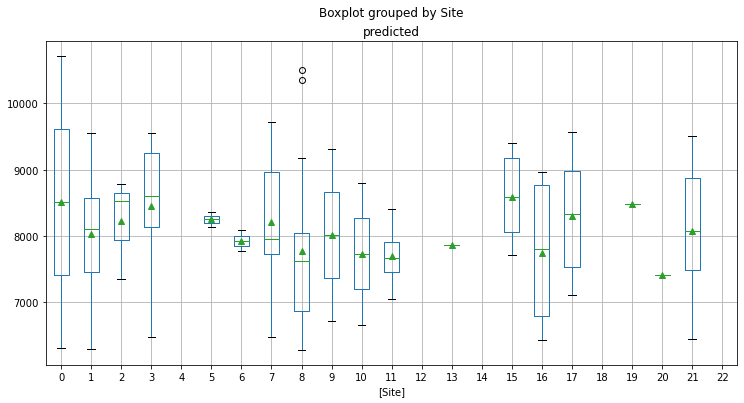

In [26]:
df_xsec['predicted'] = results.predict()
df_xsec.boxplot('predicted',by=['Site'],showmeans=True,figsize=(12,6))
df_nc=df_xsec.query('Group =="Non-carrier"')
df_nc.boxplot('predicted',by=['Site'],showmeans=True,figsize=(12,6))
df_pmc=df_xsec.query('Group =="Presymptomatic"')
df_pmc.boxplot('predicted',by=['Site'],showmeans=True,figsize=(12,6))
df_smc=df_xsec.query('Group =="Symptomatic"')
df_smc.boxplot('predicted',by=['Site'],showmeans=True,figsize=(12,6))

In general, we can see that the predicted values not only have different mean values (green triangles), but different amounts of variability as well. There are also some sites that have very low samples, making the abiity to identify their influence on the insual volume difficult to determine.

## Adding site as a covariate
Are there differences in site or scanner that are occuring in this data? A common approach has been to include a mutl-level factor variable for site or scanner intot he lineear regression. Let's run the same analysis again including the site variable as a covariate. The regression now changes to:  
$y_i  = \beta_0 + \beta_1x_{i,Age} + \beta_2x_{i,Male} + \beta_3x_{i,TIV} + \beta_4x_{i,Site_1} + \beta5x_{i,Site_2} + \ldots + \beta_{n+3}x_{i,Site_n} + \epsilon_i$

In [29]:
# Perform the regression
site_results= statsfx.ols('Insula_volume ~ Group + Age_centered + Sex + TIV_centered + Site',data=df_xsec).fit()
# Print the output summary table
print(site_results.summary())

                            OLS Regression Results                            
Dep. Variable:          Insula_volume   R-squared:                       0.735
Model:                            OLS   Adj. R-squared:                  0.723
Method:                 Least Squares   F-statistic:                     60.98
Date:                Tue, 14 Sep 2021   Prob (F-statistic):          7.83e-152
Time:                        10:32:06   Log-Likelihood:                -5082.4
No. Observations:                 622   AIC:                         1.022e+04
Df Residuals:                     594   BIC:                         1.034e+04
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                1

### Interpretation
Overall the estimates change only slightly:
* The change in the presymptomatic carriers is down from 223 to 208.
* The change in the symptomatic carriers is down from 2147 to 2087
* Age is slightly greater per year, while TIV is unchanged and Sex is still not significant.
* There are a couple of sites: Site 3,5,8 that are significantly different than site 0. Notice that Site 0 is all Siemens 3T, while 3 is Philips 3T, 5 is GE 3T, and 8 is a mix of Siemens 1.5T and Skyra 3T - so different scanners.
* The *ANOVA* test aon site and the likelihood ratio test between this model and the nested model suggest that site is adding information to the model and that here are statistically significant evidece that the site means are not equal. 
However, as you can see from the model output that all is not well. Some of this may arise due to the small sample size in some of the factors making ti difficult to get a reliabl estimate for these sites. 

## Scanner
It could be that this the difference is primarily which scanner was used, not which site it was acquired in.  In fact some sites have used more than one scanner. Soo we could run this again with scanner as the factor variabke rather than site. The primary scanner that the protocol was developed on was a Siemens Trio 3T, so let's use that as our baseline level to see how the other scanners compare.

### Interpretation
The model fits are overall pretty similar:
* The change in the presymptomatic carriers is down from 223 to 208, but still signficiantly different.
* The change in the symptomatic carriers is down from 2147 to 2087, but still signficiantly different.
* Age is slightly greater per year, while TIV is unchanged and Sex is still not significant.
* There are a couple of sites: Site 3,5,8 that are significantly different than site 0. Notice that Site 0 is all Siemens 3T, while 3 is Philips 3T, 5 is GE 3T, and 8 is a mix of Siemens 1.5T and Skyra 3T - so different scanners.
* The *ANOVA* test on site and the likelihood ratio test between this model and the nested model suggest that the site variable is adding some information to the model. 

### Scanner
It could be that this is just a scanner difference rather than what site the data was acquired, and some sites have used more than one scanner. Let's try the model again with scanner only. The primary scanner that the protocol was developed on was a Siemens Trio 3T, so let's use that as our baseline value to see how the other scanners compare.

In [32]:
df_xsec['Scanner_cat'] = pd.Categorical(df_xsec['Scanner'],
                                        categories=['Siemens Trio 3T',
                                                    'Siemens Prisma 3T',
                                                    'Siemens Skyra 3T',
                                                    'Siemens 1.5T',
                                                    'Philips 3T',
                                                    'GE 1.5T',
                                                    'GE 3T'])
# Perform the new regression model
scanner_results= statsfx.ols('Insula_volume ~ Group + Age_centered + Sex + TIV_centered + Scanner_cat',data=df_xsec).fit()
# Print the output summary table
print(scanner_results.summary())

                            OLS Regression Results                            
Dep. Variable:          Insula_volume   R-squared:                       0.720
Model:                            OLS   Adj. R-squared:                  0.714
Method:                 Least Squares   F-statistic:                     142.3
Date:                Tue, 14 Sep 2021   Prob (F-statistic):          2.74e-160
Time:                        10:38:16   Log-Likelihood:                -5099.9
No. Observations:                 622   AIC:                         1.022e+04
Df Residuals:                     610   BIC:                         1.028e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

In [33]:
# Show the ANOVA test for the different covariates
table=stats.stats.anova_lm(scanner_results, typ=2)
print(table)
# Show a likelihood ratio test comparing this with the base model above (no Site covariate)
lr_test=scanner_results.compare_lr_test(results)
print('P-value for likelihood ratio test with original mode: ', np.format_float_positional(lr_test[1],precision=6))

                    sum_sq     df           F        PR(>F)
Group         2.764545e+08    2.0  174.928557  8.965825e-61
Sex           1.021766e+06    1.0    1.293059  2.559314e-01
Scanner_cat   1.425592e+07    6.0    3.006845  6.651333e-03
Age_centered  1.461264e+08    1.0  184.925123  5.617640e-37
TIV_centered  2.887483e+08    1.0  365.415138  3.498862e-64
Residual      4.820174e+08  610.0         NaN           NaN
P-value for likelihood ratio test with original mode:  0.005917


### Interpretation
The model fits are overall pretty similar:
* The change in the presymptomatic carriers is down from 223 to 189.
* The change in the symptomatic carriers is down from 2147 to 2128
* Age and TIV are virtually unchanged.
* Except for GE 1.5T and Siemens Prisma 3T, there are many pairwise tests that show signficantly different means between scanners and the reference scanner. 
* Despite clear pairwise differences, the *ANOVA* test on site and the likelihood ratio test between this model and the nested model suggest that scanner is adding some information though perhapd not as much information a site is providing. 

### CAVEATS!
Notce the warning message that comes up in both regression equations when site or scanner is included. Given the large imbalance, small sample size, and potential heteroskedasticity between levels of this value, this is probably not an ideal, or even appropriate way to deal with the multi-site data. So where now?

### Try your own!
Now that you have seen how to do the simple regression methods above. Try them with another one of the volumes. I'll put the names below so that you can choose one have have a go.

In [46]:
list(df_xsec.columns)[10:45]

['Right_Accumbens_Area',
 'Left_Accumbens_Area',
 'Right_Amygdala',
 'Left_Amygdala',
 'Pons',
 'Brain_Stem',
 'Right_Caudate',
 'Left_Caudate',
 'Right_Hippocampus',
 'Left_Hippocampus',
 'Right_Pallidum',
 'Left_Pallidum',
 'Right_Putamen',
 'Left_Putamen',
 'Right_Thalamus_Proper',
 'Left_Thalamus_Proper',
 'Total_Brain',
 'Frontal_lobe_volume',
 'Temporal_lobe_volume',
 'Parietal_lobe_volume',
 'Occipital_lobe_volume',
 'Cingulate_volume',
 'Insula_volume',
 'Left_Frontal_lobe_volume',
 'Right_Frontal_lobe_volume',
 'Left_Temporal_lobe_volume',
 'Right_Temporal_lobe_volume',
 'Left_Parietal_lobe_volume',
 'Right_Parietal_lobe_volume',
 'Left_Occipital_lobe_volume',
 'Right_Occipital_lobe_volume',
 'Left_Cingulate_volume',
 'Right_Cingulate_volume',
 'Left_Insula_volume',
 'Right_Insula_volume']

And in the empty cell below, you can try various regressions using any of the regression models mentioend.

In [ ]:
# Show the ANOVA test for the different covariates
table=stats.stats.anova_lm(site_results, typ=2)
print(table)
# Show a likelihood ratio test comparing this with the base model above (no Site covariate)
lr_test=site_results.compare_lr_test(results)
print('P-value for likelihood ratio test with original mode: ', np.format_float_positional(lr_test[1],precision=6))

                    sum_sq     df           F        PR(>F)
Group         2.316766e+08    2.0  151.011525  9.457518e-54
Sex           9.911358e+04    1.0    0.129209  7.193818e-01
Site          4.062641e+07   22.0    2.407375  3.573990e-04
Age_centered  1.516980e+08    1.0  197.759758  5.575155e-39
TIV_centered  2.449212e+08    1.0  319.289356  1.801405e-57
Residual      4.556469e+08  594.0         NaN           NaN
P-value for likelihood ratio test with original mode:  0.000218


## ComBat approach for batch adjustment
A more recent, advanced approach to handle multi-site data is the ComBat method, originally proposed for genomic analysis and now applied quite often to imaging analyses. ComBat has a lot of advantages, as it was designed to help both with the additive bias **AND** the multiplicative bias (heteroskedasticity). In addition, it has far better suited to handle uneven data between sitesa dn samll sample sizes for those sites. So let's take a look at This is really helpful, but what if there are difference in standard error between sites, and how can we trust those small sample size in some cells. ComBat provides "harmonised" values out of the analyses that have accounted for the batch variable (here site) so that you can perform your analysis on them. There are many implementations of ComBat around for R and for Python. I am using [neuroCombat](https://github.com/Jfortin1/neuroCombat) for Python, but there is also other implementations/extensions, such as [neuroHarmonize](https://github.com/rpomponio/neuroHarmonize).

ComBat prefers lots of different features, so unlike the simple linear regression example, we will include lots of different volumes here, from the right accumbens (column 10) to the Insula volume (column 32)

In [34]:
from neuroCombat import neuroCombat
covars=df_xsec.filter(["Age_centered","TIV_centered"])
covars["Group"]=df_xsec['Group'].cat.codes
covars["Sex"]=df_xsec['Sex'].cat.codes
covars["Site"]=df_xsec['Site'].cat.codes
covars=covars[["Group","Age_centered","Sex","TIV_centered","Site"]]
categorical_cols=["Group","Sex"]
batch_col="Site"
data=df_xsec.iloc[:,10:33].to_numpy(copy=True).transpose()
data_combat = neuroCombat(dat=data,
    covars=covars,
    batch_col=batch_col,
    categorical_cols=categorical_cols)


[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments
[neuroCombat] Final adjustment of data


So now we have harmonised data, let's run again the results to see what infomration we now get for these volumes. First I'll grab the harmoinsed insula volume and add it to the data frame.

In [36]:
df_xsec['Harmonised_Insula'] = data_combat["data"][22,:].transpose()

Then I'll perform a similar regression again, this time with no site variable (as it should be harmonised by ComBat!)

In [37]:
# Perform linear regression on harmonised values.
harmonised_results= statsfx.ols('Harmonised_Insula ~ Group + Age_centered + Sex + TIV_centered',data=df_xsec).fit()
#Print Summary of regression.
print(harmonised_results.summary())

                            OLS Regression Results                            
Dep. Variable:      Harmonised_Insula   R-squared:                       0.721
Model:                            OLS   Adj. R-squared:                  0.718
Method:                 Least Squares   F-statistic:                     318.0
Date:                Tue, 14 Sep 2021   Prob (F-statistic):          5.88e-168
Time:                        10:50:08   Log-Likelihood:                -5082.8
No. Observations:                 622   AIC:                         1.018e+04
Df Residuals:                     616   BIC:                         1.020e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                1

### Interpretation
If anything, the models are a touch stronger:
* The intercept has gone slightly down from 10730mm$^3$ to 10650mm$^3$. 
* The presympotomatic carrier effect has stayed the same, but the standard error is a little lower, resulting in a slight increase in the t-statistic.
* The symptomatic carrier effect also remains the same, again with slightly less standard errro. 
* Sex remains non-significant, while Age and TIV have similar effects. 

What happens if we were to include Site as a covariate now?

In [39]:
harmonised_site_results= statsfx.ols('Harmonised_Insula ~ Group + Age_centered + Sex + TIV_centered + Site',data=df_xsec).fit()
print(harmonised_site_results.summary())

                            OLS Regression Results                            
Dep. Variable:      Harmonised_Insula   R-squared:                       0.732
Model:                            OLS   Adj. R-squared:                  0.719
Method:                 Least Squares   F-statistic:                     59.98
Date:                Tue, 14 Sep 2021   Prob (F-statistic):          2.72e-150
Time:                        10:56:16   Log-Likelihood:                -5070.4
No. Observations:                 622   AIC:                         1.020e+04
Df Residuals:                     594   BIC:                         1.032e+04
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                1

In [40]:
#ANOVA test
table=stats.stats.anova_lm(harmonised_site_results, typ=2)
print(table)
# Show a likelihood ratio test comparing this with the base model above (no Site covariate)
lr_test=harmonised_site_results.compare_lr_test(harmonised_results)
print('P-value for likelihood ratio test with original mode: ', np.format_float_positional(lr_test[1],precision=6))

                    sum_sq     df           F        PR(>F)
Group         2.352455e+08    2.0  159.393825  3.843765e-56
Sex           1.192500e+04    1.0    0.016160  8.988872e-01
Site          1.781265e+07   22.0    1.097200  3.442730e-01
Age_centered  1.472567e+08    1.0  199.551527  2.839497e-39
TIV_centered  2.357127e+08    1.0  319.420699  1.725859e-57
Residual      4.383352e+08  594.0         NaN           NaN
P-value for likelihood ratio test with original mode:  0.307898


Notice now that there is **NOT** statsitcal evidence in the *ANOVA* test, nor in the likelihood ratio test. With harmonised values, site no longer adds to the data, as would be expected.

### Try your own
Now that you can see how neuroCombat runs, grab one of the harmonised columns (perhaps one of the variables you tried in the regression above, and run the same regression with the haronised verion. Are the results similar to the insula?

### Summary
Hopefully, this demonstration showed the effects of site on statistical analysis and how ComBat is a worthwhile appproach to pursue when you need to correct for these batch effects.